In [420]:
# from scratch implementation with variables
import torch
import torch.nn.functional as F

In [421]:
words = open("../data/names.txt", "r").read().splitlines()

In [422]:
len(words)

32033

In [423]:
vocab_size = 27

# hyperparameters
# number of input tokens to predict next token
block_size = 3

# splitting intro training, validation and test sets
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# embedding dimensions
n_embed = 10
batch_size = 32

# num neurons
n_hidden = 200

training_iterations = 200000


In [424]:
# stoi and itos mapping
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Main idea: convert into examples
Examples are triplets of words

Starting from `[0] * block_size` and then adding an ending character at the back

In [425]:
def build_dataset(words: list[str]):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        chs = word + "."
        for ch in chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [426]:
import random

random.seed(42)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Main idea: set up the model weights

We have the embedding layer, the hidden layer and the output layer

In [427]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

W1 = (
    torch.randn((block_size * n_embed, n_hidden), generator=g)
    * (5 / 3)
    / (n_embed * block_size**0.5)
)
# b1 = torch.randn((n_hidden), generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

# batch norm
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

Remember to set the gradient to true

In [428]:
params = [C, W1, W2, b2, bngain, bnbias]

In [429]:
sum(p.nelement() for p in params)

12097

In [430]:
for p in params:
    p.requires_grad = True

We can start our training of the model using backpropagation

Also include an array for us to store the log loss so that we can keep track of it

In [431]:
stepi = []
lossi = []

In [432]:
for i in range(training_iterations):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    embeds = (C[Xtr[ix]]).view(-1, block_size * n_embed)

    # batch norm
    hpreact = embeds @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in params:
        p.grad = None

    loss.backward()

    learn_rate = 0.1 if i < training_iterations / 2 else 0.01
    for p in params:
        p.data += -learn_rate * p.grad

    lossi.append(loss.log10().item())
    stepi.append(i)

    # NOTE: remove for training
    break

print(loss.item())

3.3238625526428223


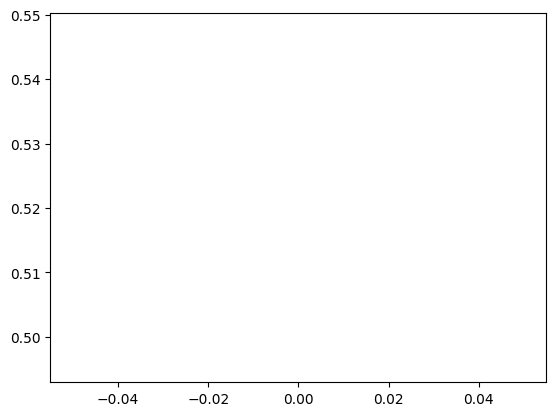

In [433]:
import matplotlib.pyplot as plt

plt.plot(stepi, lossi)

Expected loss

In [434]:
-torch.tensor(1 / 27.0).log()

tensor(3.2958)

(array([153., 196., 174., 171., 173., 173., 131., 138., 130., 124., 113.,
        140., 124., 113., 109., 120., 120., 104., 123., 105., 105., 104.,
         94., 117., 111., 111.,  85.,  88.,  72.,  98.,  94., 127., 105.,
         88., 111., 110., 127., 112., 103., 124., 134., 130., 132., 149.,
        151., 179., 158., 192., 196., 159.]),
 array([-9.97799933e-01, -9.57872003e-01, -9.17944074e-01, -8.78016144e-01,
        -8.38088214e-01, -7.98160285e-01, -7.58232355e-01, -7.18304425e-01,
        -6.78376496e-01, -6.38448566e-01, -5.98520637e-01, -5.58592707e-01,
        -5.18664777e-01, -4.78736848e-01, -4.38808918e-01, -3.98880988e-01,
        -3.58953059e-01, -3.19025129e-01, -2.79097199e-01, -2.39169270e-01,
        -1.99241340e-01, -1.59313411e-01, -1.19385481e-01, -7.94575512e-02,
        -3.95296216e-02,  3.98308039e-04,  4.03262377e-02,  8.02541673e-02,
         1.20182097e-01,  1.60110027e-01,  2.00037956e-01,  2.39965886e-01,
         2.79893816e-01,  3.19821745e-01,  3.59749

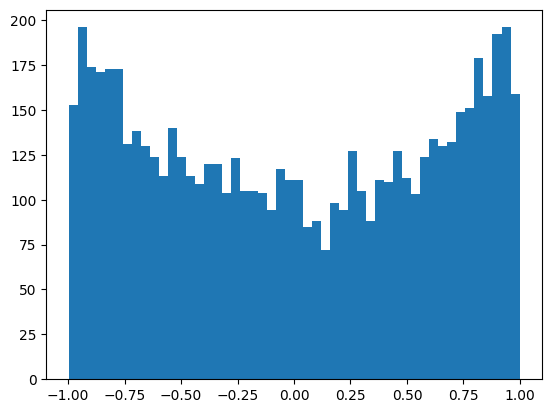

In [435]:
plt.hist(h.view(-1).tolist(), 50)

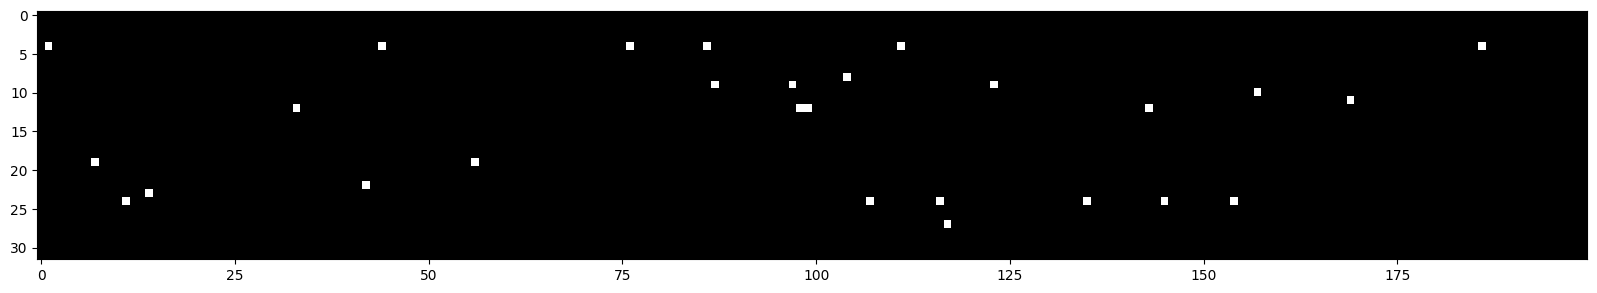

In [436]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

In [437]:
(torch.randn(10000) * 5 / 3 / (30**0.5)).std()


tensor(0.3072)

In [438]:
# torchifying our code
from torch import Tensor


class Linear:
    def __init__(self, fan_in: int, fan_out: int, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x: Tensor):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self) -> list[Tensor]:
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]


class BatchNorm1d:
    # assume affine True (will be using gamma and beta)
    # track running stats is true
    def __init__(self, dim: int, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters
        # the bngain and bnbias
        self.gamma = torch.ones(dim)  # initially scale as 1
        self.beta = torch.zeros(dim)  # initially no shift

        # buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)  # initially for normal distr mean is 0
        self.running_var = torch.ones(dim)  # initially for normal distri var is 1

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # not in pytorch - just to make it easier to calculate statistics
        self.out = self.gamma * xhat + self.beta

        if self.training:
            # exponential weighted average
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xmean

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


# activation layer
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1

    # for all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3
            # layer.weight *= 2

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

174751


In [439]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)  # concatenate
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    # update gradients
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

    # remove after debug
    if i > 1000:
        break


      0/ 200000: 3.290613


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.73%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.84%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.45%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.45%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.53%


Text(0.5, 1.0, 'activation distribution')

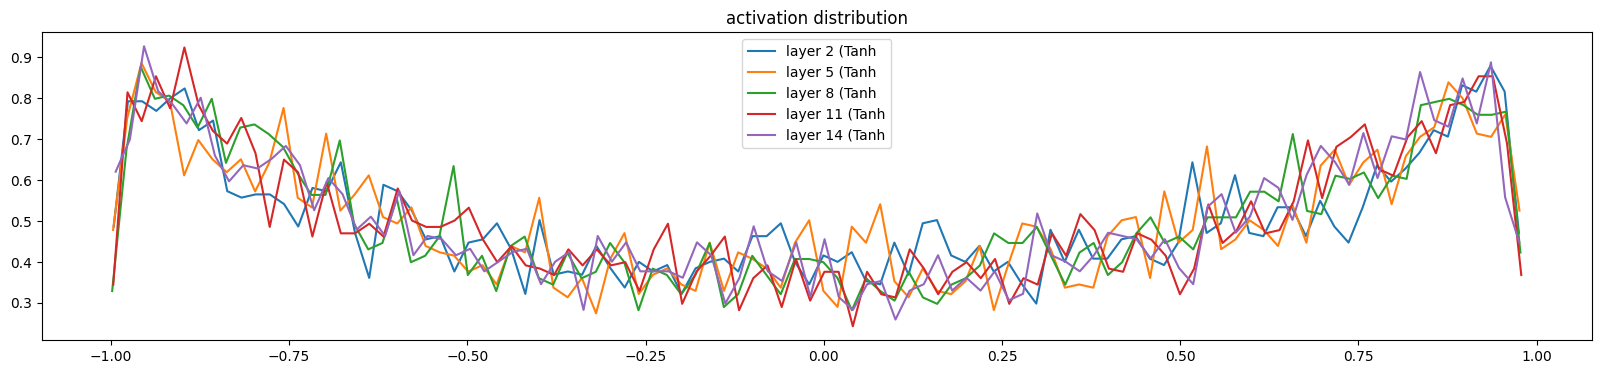

In [440]:
# copied from notebook

# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 1.847293e-03
layer 5 (      Tanh): mean -0.000000, std 1.579786e-03
layer 8 (      Tanh): mean -0.000000, std 1.434801e-03
layer 11 (      Tanh): mean +0.000000, std 1.369157e-03
layer 14 (      Tanh): mean +0.000000, std 1.333013e-03


Text(0.5, 1.0, 'gradient distribution')

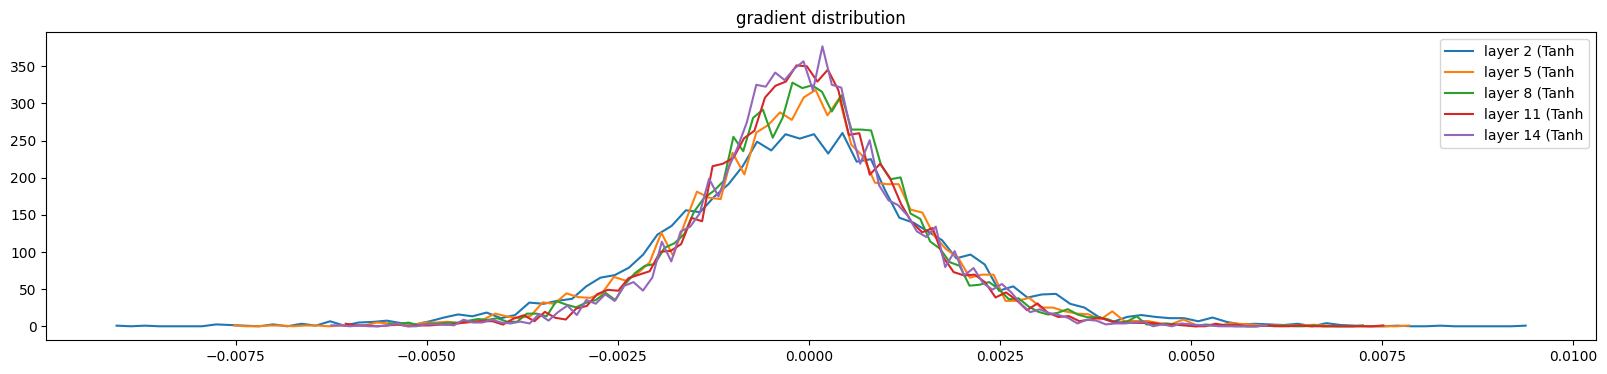

In [441]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean -0.000000 | std 7.572270e-03 | grad:data ratio 7.597312e-03
weight  (30, 200) | mean +0.000088 | std 4.777489e-03 | grad:data ratio 1.578199e-02
weight (200, 200) | mean -0.000016 | std 3.767684e-03 | grad:data ratio 3.180232e-02
weight (200, 200) | mean +0.000012 | std 3.166301e-03 | grad:data ratio 2.668132e-02
weight (200, 200) | mean -0.000007 | std 2.907118e-03 | grad:data ratio 2.455561e-02
weight (200, 200) | mean -0.000000 | std 2.846576e-03 | grad:data ratio 2.414095e-02
weight  (200, 27) | mean +0.000019 | std 7.626554e-03 | grad:data ratio 6.429546e-02


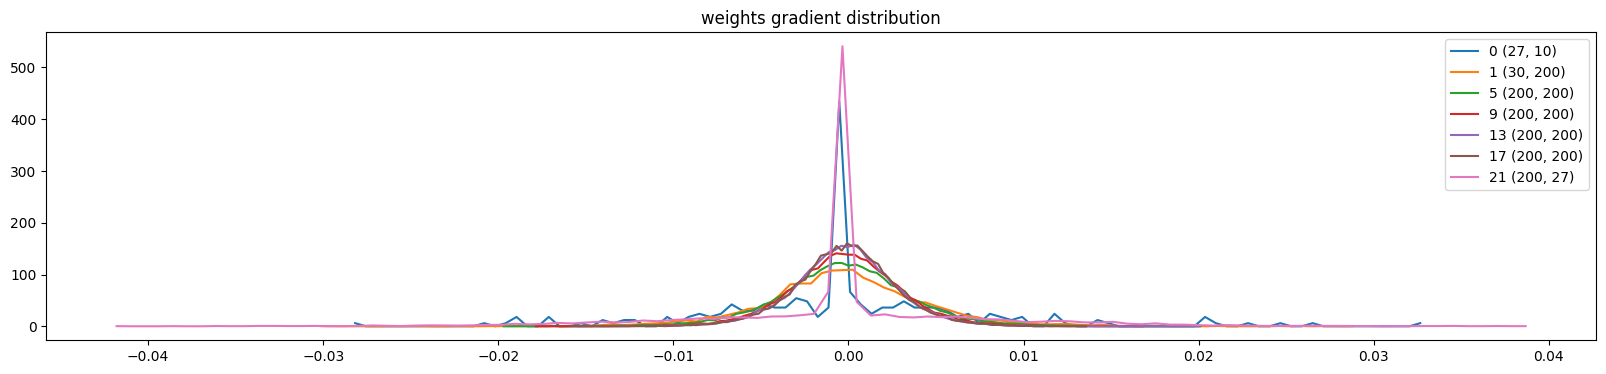

In [442]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

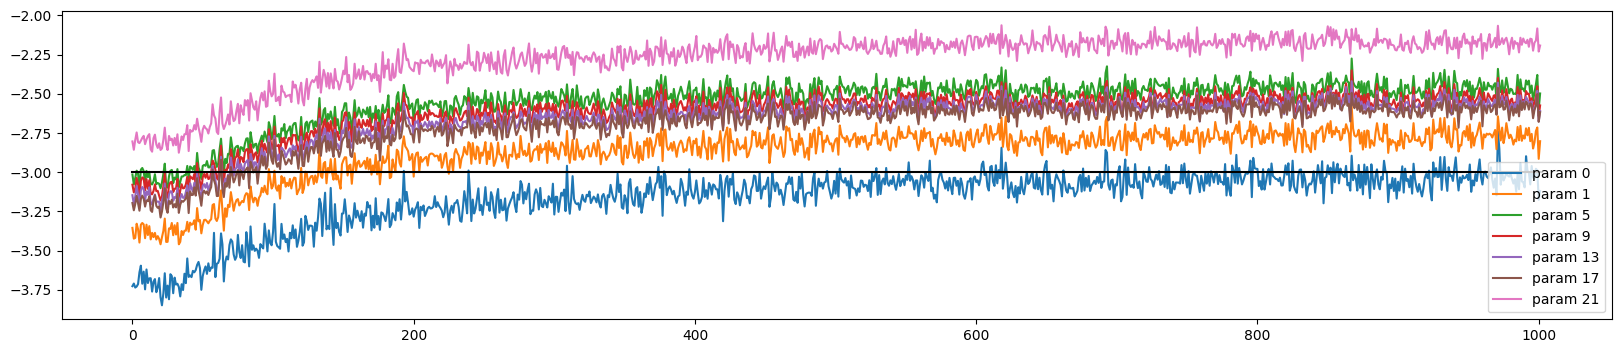

In [443]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);